In [1]:

# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cu113
torch version: 2.3.1+cu121
torchvision version: 0.18.1+cu121


DEPRECATION: Loading egg at c:\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision
import sys

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the scripts directory, download it from GitHub if it doesn't work
try:
    from scripts import data_setup, engine
    from scripts.helper_functions import download_data, set_seeds, plot_loss_curves
except:
    print("[INFO] Couldn't find scripts or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/radoslaw626/TinyVGG
    !move TinyVGG/scripts .
    !rd /s /q TinyVGG
    sys.path.append('scripts')
    from scripts import data_setup, engine
    from scripts.helper_functions import download_data, set_seeds, plot_loss_curves

In [3]:

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:

# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [5]:

# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:


from torchvision import transforms
from scripts import data_setup

# Create image size 
IMG_SIZE = 224 # comes from Table 3 of the ViT paper

# Create transforms pipeline
manual_transforms = transforms.Compose([
                                        transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                        transforms.ToTensor()
])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [8]:


# Create a batch size of 32 (gthe paper uses 4096 but this may be too big for our smaller hardware... can always scale up later)
BATCH_SIZE = 32 

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transform=manual_transforms,
    test_transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [9]:


# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the single image and label shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

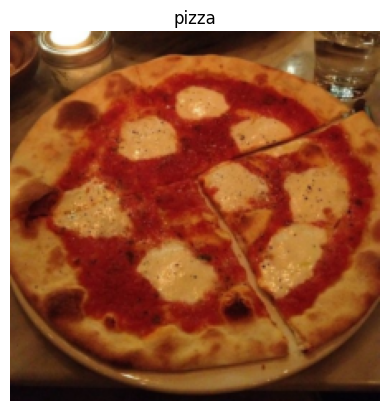

In [10]:


# Plot the image with matplotlib
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0)) # (color_channels, height, width) -> (height, width, color_channels)
plt.title(class_names[label])
plt.axis(False);

In [11]:
height = 224
width = 224
color_channels = 3
patch_size = 16

num_of_patches = int((height*width) / patch_size**2)
num_of_patches

196

In [12]:
#input shape
embedding_layer_input_shape = (height, width, color_channels)

#output shape
embedding_layer_output_shape = (num_of_patches, patch_size**2 * color_channels)

embedding_layer_input_shape, embedding_layer_output_shape

((224, 224, 3), (196, 768))

(-0.5, 223.5, 223.5, -0.5)

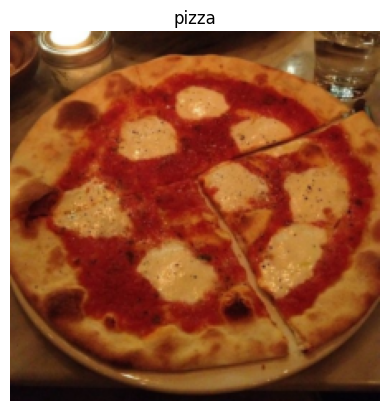

In [13]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

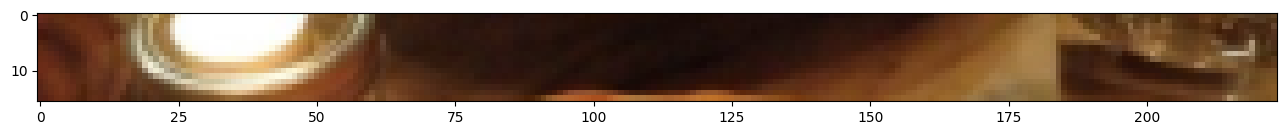

In [14]:
image_permuted = image.permute(1, 2 , 0)

patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

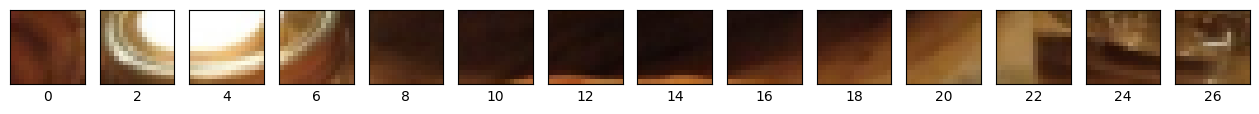

In [15]:
img_size = 224
patch_size = 16

num_patches = img_size/patch_size

assert img_size % patch_size == 0, "image size must be divisible by patch size"

fig, axs = plt.subplots(nrows=1,
ncols=img_size // patch_size,
sharex=True,
sharey=True,
figsize=(patch_size, patch_size))

for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
    axs[i].set_xlabel(i+i)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

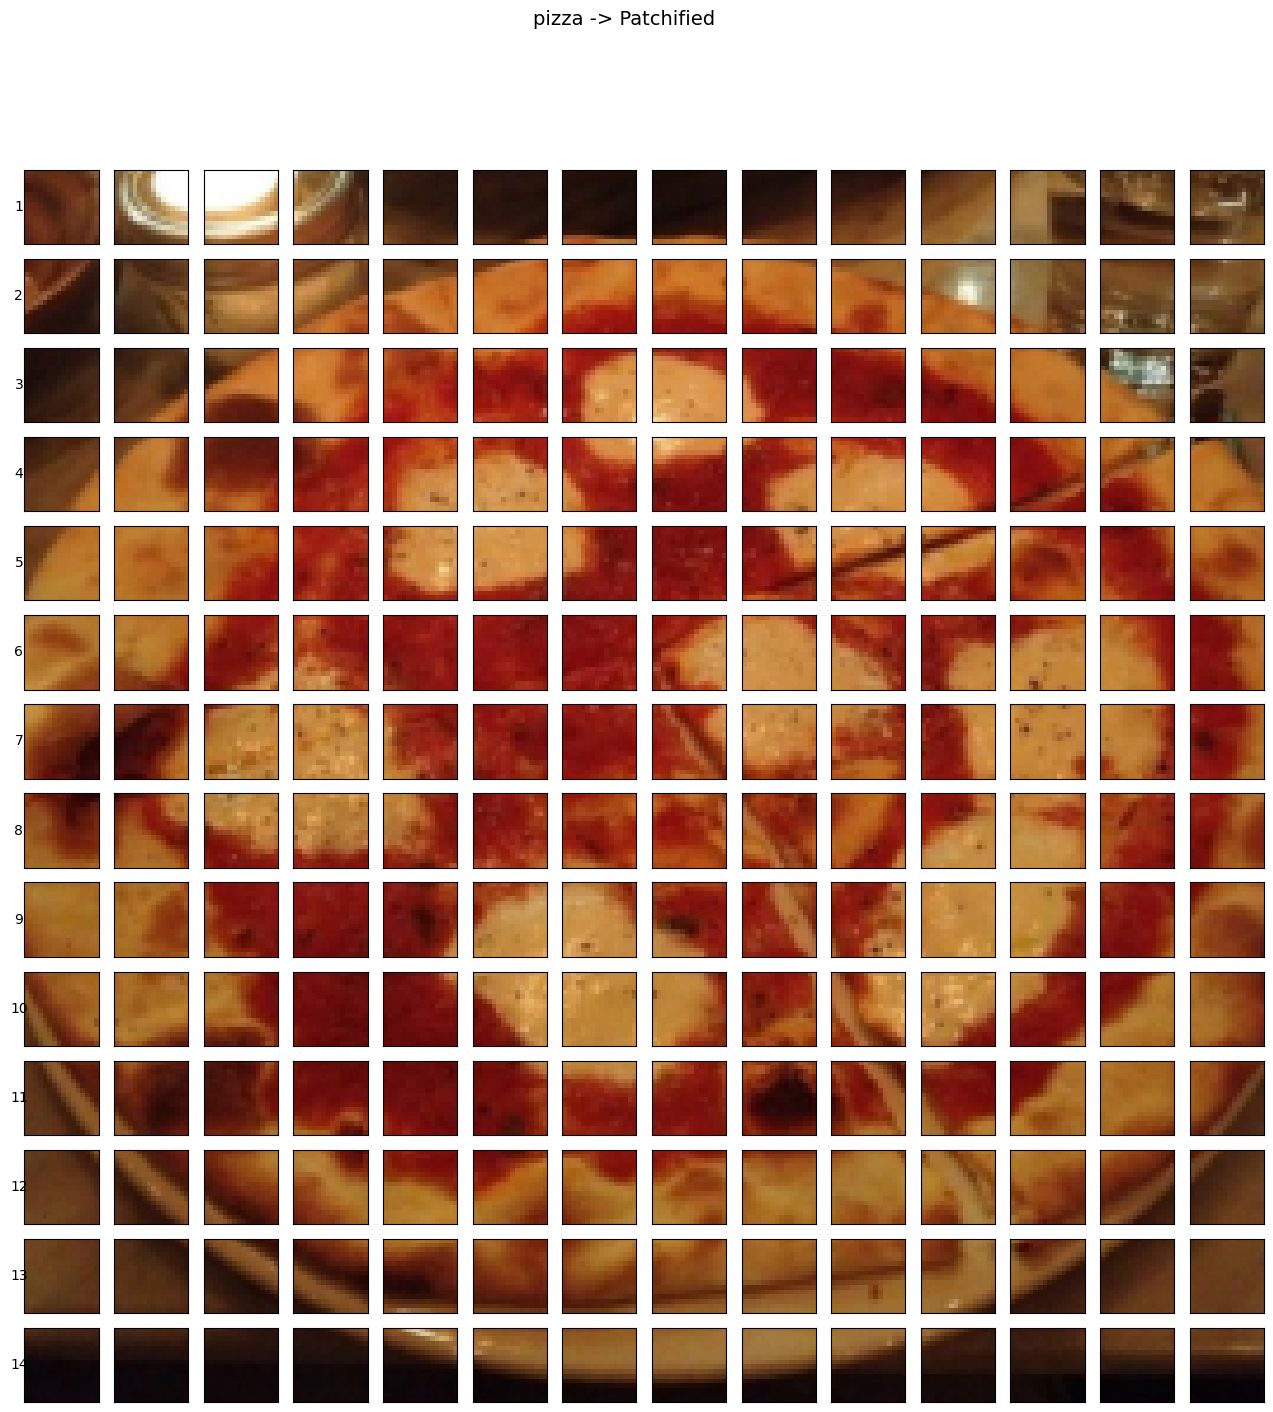

In [16]:
img_size = 224
patch_size = 16

num_patches = img_size/patch_size

assert img_size % patch_size == 0, "image size must be divisible by patch size"

fig, axs = plt.subplots(
    ncols=img_size // patch_size,
	nrows=img_size // patch_size,
	sharex=True,
	sharey=True,
	figsize=(patch_size, patch_size))

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                        patch_width:patch_width+patch_size,
                                        :])
        axs[i, j].set_ylabel(
            i+1,
			rotation="horizontal",
            verticalalignment="center")
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
plt.show()

In [17]:
from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(-0.5, 223.5, 223.5, -0.5)

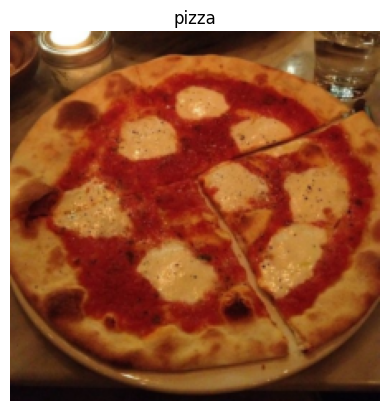

In [18]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [19]:
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


[170, 220, 40, 292, 41]


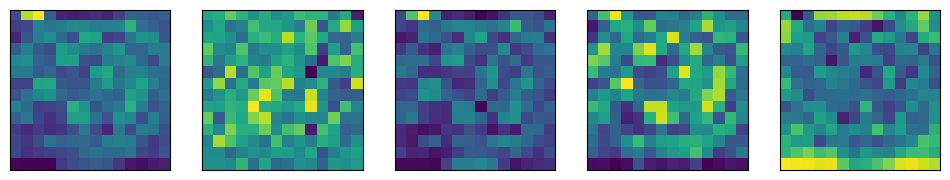

In [20]:
import random
random_indexes = random.sample(range(0, 758), k=5)
print(random_indexes)

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [21]:
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.0536,  0.1790, -0.1680, -0.1402, -0.0113, -0.0356, -0.0736,
           -0.0720, -0.0129,  0.0686,  0.0705, -0.0626, -0.0115,  0.0024],
          [-0.1052,  0.0413,  0.1039, -0.0946,  0.1244, -0.0155, -0.0794,
           -0.0868,  0.0013, -0.0363,  0.2017, -0.0324,  0.0066, -0.0707],
          [ 0.0327, -0.0147,  0.0814, -0.0521, -0.0945, -0.1841,  0.1533,
            0.1344, -0.0854, -0.1904, -0.1142,  0.0880,  0.2082, -0.0029],
          [ 0.0413, -0.0661, -0.0295, -0.1328,  0.0532,  0.0780, -0.2457,
           -0.2845,  0.0226,  0.1357, -0.0090, -0.1493,  0.0466, -0.0263],
          [ 0.0247, -0.0439, -0.1029, -0.1345,  0.0409,  0.0365, -0.1146,
           -0.0848, -0.0962, -0.1953, -0.0053, -0.0555, -0.0939, -0.0671],
          [-0.0306, -0.0508, -0.0851, -0.0605, -0.1355, -0.0900, -0.1297,
            0.1650,  0.0611, -0.0957,  0.0848,  0.0238, -0.0765, -0.0532],
          [-0.1587, -0.0326,  0.0409,  0.0484, -0.0729, -0.0956, -0.1489,
            0.0054, -0.0419, -0.

In [22]:
from torch import nn

flatten_layer = nn.Flatten(start_dim = 2,
                           end_dim=3)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

shape torch.Size([3, 224, 224])
shape after conv torch.Size([1, 768, 14, 14])
flatten out of conv shape: torch.Size([1, 768, 196])


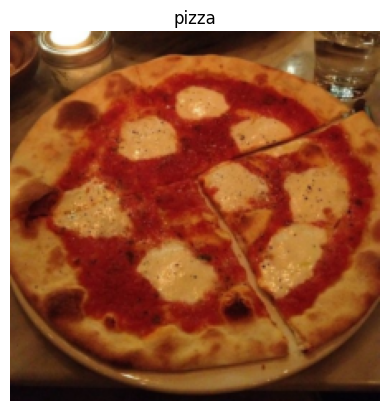

In [23]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"shape {image.shape}")

image_out_of_conv = conv2d(image.unsqueeze(0))
print(f"shape after conv {image_out_of_conv.shape}")

image_out_of_conv_flattened = flatten_layer(image_out_of_conv)

print(f"flatten out of conv shape: {image_out_of_conv_flattened.shape}")

In [24]:
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1)
image_out_of_conv_flattened_reshaped.shape

torch.Size([1, 196, 768])

(-0.5, 195.5, 0.5, -0.5)

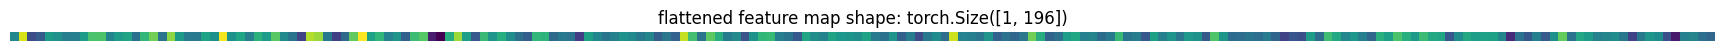

In [25]:
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0]

plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

In [26]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        self.patch_size=patch_size
        
        self.patcher = nn.Conv2d(in_channels=in_channels,
                           out_channels=embedding_dim,
                           kernel_size=patch_size,
                           stride=patch_size,
                           padding=0)
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)
    def forward(self, x):
           image_resolution = x.shape[-1]
           assert image_resolution % patch_size == 0, f"input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
           x_patched = self.patcher(x)
           x_flattened = self.flatten(x_patched)
           return x_flattened.permute(0, 2, 1)


In [27]:
set_seeds()

patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

print(f"input img size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"output img size: {patch_embedded_image.shape}")

input img size: torch.Size([1, 3, 224, 224])
output img size: torch.Size([1, 196, 768])


In [28]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad = torch.randn(1, 3, 225, 225)

patchify(rand_image_tensor)

tensor([[[-0.3601,  0.2602, -0.7408,  ..., -1.2910, -0.2012, -0.0354],
         [-0.3405,  0.6132,  0.6626,  ..., -0.6314, -1.8604,  0.3311],
         [-0.0176, -0.2323, -0.1009,  ...,  0.1873,  0.6899, -0.5419],
         ...,
         [ 0.5333, -0.7641, -0.1217,  ...,  0.2381,  0.5565,  0.0466],
         [-0.6577, -0.0324, -0.6278,  ..., -0.1591,  0.7905,  1.4529],
         [-1.1716, -0.1617, -0.1427,  ...,  0.5600,  0.4640,  0.7539]]],
       grad_fn=<PermuteBackward0>)

In [29]:
patch_embedded_image

tensor([[[-0.2880,  0.0207, -0.0202,  ...,  0.1726, -0.1549,  0.1002],
         [-0.9115,  0.3296,  0.0973,  ...,  0.5513, -0.4161,  0.0314],
         [-0.8253,  0.1406,  0.1067,  ...,  0.6927, -0.6878,  0.2747],
         ...,
         [-0.1197,  0.0493, -0.0398,  ...,  0.0489, -0.0699,  0.0079],
         [-0.1463,  0.0549, -0.0067,  ...,  0.0743, -0.1155, -0.0528],
         [-0.1656,  0.0561,  0.0338,  ...,  0.0673, -0.1294, -0.0860]]],
       grad_fn=<PermuteBackward0>)

In [30]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [31]:
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)

class_token.shape

torch.Size([1, 1, 768])

In [32]:
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1)

patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.2880,  0.0207, -0.0202,  ...,  0.1726, -0.1549,  0.1002],
          [-0.9115,  0.3296,  0.0973,  ...,  0.5513, -0.4161,  0.0314],
          ...,
          [-0.1197,  0.0493, -0.0398,  ...,  0.0489, -0.0699,  0.0079],
          [-0.1463,  0.0549, -0.0067,  ...,  0.0743, -0.1155, -0.0528],
          [-0.1656,  0.0561,  0.0338,  ...,  0.0673, -0.1294, -0.0860]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [33]:
number_of_patches = int((height * width)/patch_size**2)

embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]


position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension))

position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [34]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedding.shape, patch_and_position_embedding

(torch.Size([1, 197, 768]),
 tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [0.7120, 1.0207, 0.9798,  ..., 1.1726, 0.8451, 1.1002],
          [0.0885, 1.3296, 1.0973,  ..., 1.5513, 0.5839, 1.0314],
          ...,
          [0.8803, 1.0493, 0.9602,  ..., 1.0489, 0.9301, 1.0079],
          [0.8537, 1.0549, 0.9933,  ..., 1.0743, 0.8845, 0.9472],
          [0.8344, 1.0561, 1.0338,  ..., 1.0673, 0.8706, 0.9140]]],
        grad_fn=<AddBackward0>))

In [35]:
set_seeds()

patch_size = 16

print(f"image shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(0)
print(f"input image shape: {x.shape}")

patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

patch_embedding = patch_embedding_layer(x)
print(f"patch embedding shape: {patch_embedding.shape}")

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)

print(f"class_token shape: {class_token.shape}")

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)

print(f"patch embedding with class token shape: {patch_embedding_class_token.shape}")

number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"patch and position embedding shape: {patch_and_position_embedding.shape}")

image shape: torch.Size([3, 224, 224])
input image shape: torch.Size([1, 3, 224, 224])
patch embedding shape: torch.Size([1, 196, 768])
class_token shape: torch.Size([1, 1, 768])
patch embedding with class token shape: torch.Size([1, 197, 768])
patch and position embedding shape: torch.Size([1, 197, 768])


In [36]:
class MultiHeadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 attn_dropout:float=0):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)
    def forward(self, x):
        self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                key=x,
                value=x,
                need_weights=False)
        return attn_output

In [37]:
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads=12,
                                                             attn_dropout=0)

patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)

print(f"shape after msa block: {patched_image_through_msa_block.shape}")

shape after msa block: torch.Size([1, 197, 768])


In [38]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.7120, 1.0207, 0.9798,  ..., 1.1726, 0.8451, 1.1002],
         [0.0885, 1.3296, 1.0973,  ..., 1.5513, 0.5839, 1.0314],
         ...,
         [0.8803, 1.0493, 0.9602,  ..., 1.0489, 0.9301, 1.0079],
         [0.8537, 1.0549, 0.9933,  ..., 1.0743, 0.8845, 0.9472],
         [0.8344, 1.0561, 1.0338,  ..., 1.0673, 0.8706, 0.9140]]],
       grad_fn=<AddBackward0>)

In [39]:
patched_image_through_msa_block

tensor([[[ 0.6354, -0.1356, -0.5388,  ...,  0.2995, -0.5658, -0.1265],
         [ 0.6325, -0.1378, -0.5392,  ...,  0.3002, -0.5658, -0.1267],
         [ 0.6326, -0.1373, -0.5389,  ...,  0.2999, -0.5657, -0.1266],
         ...,
         [ 0.6324, -0.1378, -0.5394,  ...,  0.3004, -0.5658, -0.1266],
         [ 0.6326, -0.1378, -0.5393,  ...,  0.3004, -0.5658, -0.1267],
         [ 0.6326, -0.1378, -0.5393,  ...,  0.3004, -0.5659, -0.1267]]],
       grad_fn=<TransposeBackward0>)

In [40]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 dropout:float=0.1):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
                      
        )
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [41]:
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f" input shape of mlp block: {patched_image_through_msa_block.shape}")
print(f"output shape of mlp block: {patched_image_through_mlp_block.shape}")

 input shape of mlp block: torch.Size([1, 197, 768])
output shape of mlp block: torch.Size([1, 197, 768])


In [42]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 mlp_size:int=3072,
                 mlp_dropout:float=0.1,
                 attn_dropout:float=0):
        super().__init__()

        self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                  mlp_size=mlp_size,
                                  dropout=mlp_dropout)

    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x

In [43]:
transformer_encoder_block = TransformerEncoderBlock()

summary(model=transformer_encoder_block,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


C:\Users\mical\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\activation.py:1221: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  return torch._native_multi_head_attention(


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [44]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                             nhead=12,
                                                             dim_feedforward=3072,
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [45]:


summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"],
        depth=3)


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

In [46]:
class ViT(nn.Module):
    def __init__(self,
                 img_size:int=224,
                 in_channels:int=3,
                 patch_size:int=16,
                 num_transformer_layers:int=12,
                 embedding_dim:int=768,
                 mlp_size=3072,
                 num_heads:int=12,
                 attn_dropout:float=0.0,
                 mlp_dropout:float=0.1,
                 embedding_dropout:float=0.1,
                 num_classes:int=1000):
        super().__init__()
        
        assert img_size % patch_size == 0, f"image size must be divisible by patch size, img.size {img_size}, patch size: {patch_size}"

        self.num_patches = (img_size * img_size) // patch_size**2

        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                           requires_grad=True)
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim))

        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                          num_heads=num_heads,
                                                                          mlp_size=mlp_size,
                                                                          mlp_dropout=mlp_dropout,
                                                                          attn_dropout=attn_dropout) for _ in range(num_transformer_layers)])
        
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        class_token = self.class_embedding.expand(batch_size, -1, -1)

        x = self.patch_embedding(x)
        x = torch.cat((class_token, x), dim=1)
        x = self.position_embedding + x
        x = self.embedding_dropout(x)
        x = self.transformer_encoder(x)
        x = self.classifier(x[:, 0])
        
        return x

In [47]:
batch_size = 32
embedding_dim = 768
class_embedding  = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                requires_grad=True)
class_embedding_expanded =  class_embedding.expand(batch_size, -1, -1)
class_embedding.shape, class_embedding_expanded.shape

(torch.Size([1, 1, 768]), torch.Size([32, 1, 768]))

In [48]:
vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiHeadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
  

In [49]:
set_seeds()

random_image_tensor = torch.randn(1, 3, 224, 224)

vit = ViT(num_classes=len(class_names))

vit(random_image_tensor)

tensor([[-0.2563,  0.6465,  1.1302]], grad_fn=<AddmmBackward0>)

In [50]:
from torchinfo import summary

summary(model=ViT(num_classes=len(class_names)),
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

In [53]:
from scripts import engine


optimizer = torch.optim.Adam(vit.parameters(),
                             lr=1e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.1)

loss_fn = torch.nn.CrossEntropyLoss()

vit = vit.to(device)
result = engine.train(model=vit,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      epochs=10,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.9358 | train_acc: 0.3203 | test_loss: 1.5866 | test_acc: 0.1979
Epoch: 2 | train_loss: 1.5996 | train_acc: 0.2695 | test_loss: 1.0655 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.3187 | train_acc: 0.3008 | test_loss: 1.3612 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1849 | train_acc: 0.4141 | test_loss: 1.2187 | test_acc: 0.5417
Epoch: 5 | train_loss: 1.2992 | train_acc: 0.2930 | test_loss: 1.7008 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.3048 | train_acc: 0.2930 | test_loss: 1.1997 | test_acc: 0.2604
Epoch: 7 | train_loss: 1.1282 | train_acc: 0.3750 | test_loss: 1.8854 | test_acc: 0.2604
Epoch: 8 | train_loss: 1.4124 | train_acc: 0.3125 | test_loss: 1.2805 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.2798 | train_acc: 0.2734 | test_loss: 1.4263 | test_acc: 0.1979
Epoch: 10 | train_loss: 1.3083 | train_acc: 0.2852 | test_loss: 1.5909 | test_acc: 0.2604
